# Draft

In [2]:
import torch 
import torchvision
import numpy as np
from fastai.vision.all import * 
import time

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

In [4]:
#hide
graphviz.set_jupyter_format('png')

'svg'

## CNN 다중클래스 분류(multiclass classification)의 구현 

### 결론 (그냥 외우세요)

`-` 2개의 class를 구분하는 문제가 아니라 $k$개의 class를 구분해야 한다면? 

***일반적인 개념*** 

- 손실함수: BCE loss $\to$ Cross Entropy loss 
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- 마지막층의 활성화: sig $\to$ softmax 

***파이토치 한정*** 
- **y의형태: (n,) vector + int형 // (n,k) one-hot encoded vector + float형**
- 손실함수: torch.nn.BCEWithLogitsLoss,  $\to$ torch.nn.CrossEntropyLoss
- 마지막층의 선형변환: torch.Linear(?,1) $\to$ torch.Linear(?,k) 
- 마지막층의 활성화: None $\to$ None (손실함수에 이미 마지막층의 활성화가 포함) 

### 실습: 3개의 클래스를 구분 

In [5]:
path = untar_data(URLs.MNIST)

training set 

In [6]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2])/255
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

test set 

In [7]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/2').ls()])
XX = torch.concat([X0,X1,X2])/255
yy = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

(1) dls

In [8]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy) 
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [9]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)

In [10]:
net1(X).shape

torch.Size([18623, 2304])

In [11]:
net = torch.nn.Sequential(
    net1,
    torch.nn.Linear(2304,3)
)
loss_fn = torch.nn.CrossEntropyLoss() 

In [12]:
lrnr = Learner(dls,net,loss_fn) 

(3) 학습

In [13]:
lrnr.fit(10)

epoch,train_loss,valid_loss,time
0,2.151101,1.147814,00:01
1,1.330549,0.779813,00:00
2,1.096805,0.526271,00:00
3,0.888589,0.339096,00:00
4,0.692414,0.221098,00:00
5,0.546715,0.155111,00:00
6,0.434344,0.120085,00:00
7,0.348444,0.099850,00:00
8,0.283795,0.086756,00:00
9,0.234494,0.077523,00:00


(4) 적합결과 

In [14]:
lrnr.model.to("cpu")

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Linear(in_features=2304, out_features=3, bias=True)
)

In [15]:
_df = pd.DataFrame(lrnr.model(XX).data).assign(y=yy) 
_df

,0,1,2,y
0,1.729592,-10.913298,-1.649679,0
1,1.312381,-5.554585,-2.429552,0
2,0.441012,-6.587088,-1.895368,0
3,2.451756,-6.568151,-3.995848,0
4,1.654882,-9.140928,-2.133361,0
...,...,...,...,...
3142,-4.989231,-5.715702,1.215653,2
3143,-1.857672,-6.067428,-0.694055,2
3144,-1.783689,-6.431767,0.368422,2
3145,-2.351225,-6.022075,0.170130,2


In [16]:
_df.query('y==0') # column 0 의 값이 높음 

,0,1,2,y
0,1.729592,-10.913298,-1.649679,0
1,1.312381,-5.554585,-2.429552,0
2,0.441012,-6.587088,-1.895368,0
3,2.451756,-6.568151,-3.995848,0
4,1.654882,-9.140928,-2.133361,0
...,...,...,...,...
975,3.928554,-11.821769,-3.705594,0
976,0.997334,-11.824551,-1.101999,0
977,2.239882,-8.936161,-2.226652,0
978,1.853237,-10.906685,-1.834271,0


In [17]:
_df.query('y==1') # column 1 의 값이 높음 

,0,1,2,y
980,-4.871256,2.614453,-1.767863,1
981,-4.899054,2.159775,-2.165224,1
982,-4.402391,2.795234,-2.371586,1
983,-4.820839,2.056655,-1.459860,1
984,-4.405687,2.936391,-2.114895,1
...,...,...,...,...
2110,-4.029782,2.663404,-2.119827,1
2111,-3.550334,2.510710,-2.295244,1
2112,-4.463938,2.776460,-1.990713,1
2113,-4.634441,1.386467,-0.746717,1


In [18]:
_df.query('y==2') # column 2 의 값이 높음 

,0,1,2,y
2115,-4.473395,-3.103557,0.136305,2
2116,-2.472383,-5.181675,-0.647408,2
2117,-5.336338,-6.574993,1.521194,2
2118,-3.662260,-6.081661,0.840216,2
2119,-1.148340,-5.849408,-0.644603,2
...,...,...,...,...
3142,-4.989231,-5.715702,1.215653,2
3143,-1.857672,-6.067428,-0.694055,2
3144,-1.783689,-6.431767,0.368422,2
3145,-2.351225,-6.022075,0.170130,2


### 공부: Softmax 

`-` 눈치 

`-` torch.nn.Softmax() 손계산 

(예시1) -- 잘못계산

In [19]:
sftmax = torch.nn.Softmax(dim=0)

In [20]:
_netout = torch.tensor([[-2.0,-2.0,0.0],[3.14,3.14,3.14],[0.0,0.0,2.0],[2.0,2.0,4.0],[0.0,0.0,0.0]])
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [21]:
sftmax(_netout)

tensor([[0.0041, 0.0041, 0.0115],
        [0.7081, 0.7081, 0.2653],
        [0.0306, 0.0306, 0.0848],
        [0.2265, 0.2265, 0.6269],
        [0.0306, 0.0306, 0.0115]])

(예시2) -- 보통은 이게 맞는거 

In [22]:
sftmax = torch.nn.Softmax(dim=1)

In [23]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [24]:
sftmax(_netout)

tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시3) -- 차원명시안하면 맞게 계산해주고 경고 한번 줌 

In [25]:
sftmax = torch.nn.Softmax()

In [26]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [27]:
sftmax(_netout)

/home/cgb4/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시4) -- 손계산으로 따라하기

In [28]:
np.apply_along_axis(lambda x: np.exp(x)/np.exp(x).sum(),1,_netout)

array([[0.10650698, 0.10650698, 0.78698605],
       [0.33333334, 0.33333334, 0.33333334],
       [0.10650699, 0.10650699, 0.78698605],
       [0.10650698, 0.10650698, 0.78698605],
       [0.33333334, 0.33333334, 0.33333334]], dtype=float32)

### 공부: CrossEntropyLoss

#### `#` ***torch.nn.CrossEntropyLoss() 손계산: one-hot version***

In [29]:
loss_fn = torch.nn.CrossEntropyLoss()

In [30]:
_netout 

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [31]:
_y_onehot = torch.tensor([[0.0,0.0,1.0],[0.0,1.0,0.0],[0.0,0.0,1.0],[0.0,0.0,1.0],[1.0,0.0,0.0]])
_y_onehot

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.]])

In [32]:
sftmax = torch.nn.Softmax(dim=1) # 경고 자꾸 뜨는거 꼴보기 싫어서 새로 다시 만듬
sftmax(_netout), _y_onehot

(tensor([[0.1065, 0.1065, 0.7870],
         [0.3333, 0.3333, 0.3333],
         [0.1065, 0.1065, 0.7870],
         [0.1065, 0.1065, 0.7870],
         [0.3333, 0.3333, 0.3333]]),
 tensor([[0., 0., 1.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]))

`-` 계산결과 

In [33]:
loss_fn(_netout,_y_onehot)

tensor(0.5832)

In [34]:
-torch.sum((torch.log(sftmax(_netout)) * _y_onehot)) / 5 ## 5는 obs의 수 

tensor(0.5832)

`-` 계산하는 방법도 중요한데 torch.nn.CrossEntropyLoss() 에는 softmax 활성화 함수가 이미 포함되어 있다는 것을 깨닫는 것이 더 중요함 

`-` 따라서 CrossEntropyLoss = Softmax + CrossEntropyLoss // 따라서 엄밀하게는 CEWithSoftmaxLoss 정도로 써야 맞음

#### `#` ***torch.nn.CrossEntropyLoss() 손계산: lenght $n$ vertor version***

In [35]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [36]:
_y_onehot

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.]])

In [37]:
_y = torch.tensor([2,1,2,2,0]) 

In [38]:
loss_fn(_netout,_y)

tensor(0.5832)

### 실습: $k=2$로 두면 이진분류도 가능

`-` download data 

In [39]:
path = untar_data(URLs.MNIST)

`-` training set 

In [40]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set 

In [41]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [42]:
y_onehot = torch.nn.functional.one_hot(y.reshape(-1).to(torch.int64)).to(torch.float32)
yy_onehot = torch.nn.functional.one_hot(yy.reshape(-1).to(torch.int64)).to(torch.float32)

`-` 사용방법

(1) dls 만들기 

In [43]:
ds1 = torch.utils.data.TensorDataset(X,y_onehot)
ds2 = torch.utils.data.TensorDataset(XX,yy_onehot) 
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [44]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss() 
lrnr = Learner(dls,net,loss_fn,metrics=accuracy_multi)

(3) 학습

In [45]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.320423,0.592241,0.463357,00:00
1,0.761445,0.428757,0.737825,00:00
2,0.601741,0.167185,0.995035,00:00
3,0.449909,0.095064,0.996217,00:00
4,0.338323,0.052708,0.996454,00:00
5,0.259306,0.034093,0.996454,00:00
6,0.202594,0.024260,0.996454,00:00
7,0.160498,0.018835,0.997163,00:00
8,0.128566,0.015493,0.997400,00:00
9,0.103977,0.013136,0.997400,00:00


(4) 예측 및 시각화

In [46]:
net.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=2, bias=True)
)

Text(0.5, 0.98, 'Training Set')

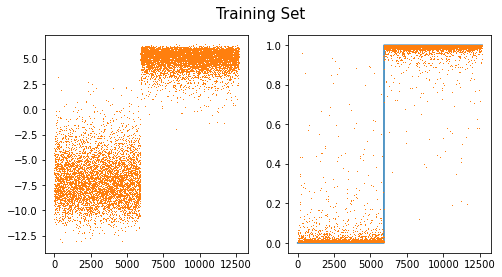

In [47]:
sftmax = torch.nn.Softmax(dim=1) 
sig = torch.nn.Sigmoid()
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X).diff(axis=1).data,',',color="C1")
ax[1].plot(y)
ax[1].plot(sftmax(net(X))[:,1].data,',')
#ax[1].plot(sig(net(X).diff(axis=1)).data,',')
fig.suptitle("Training Set",size=15)

Text(0.5, 0.98, 'Test Set')

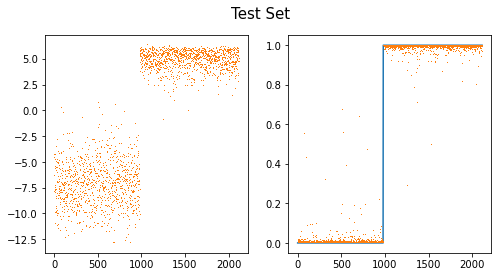

In [48]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX).diff(axis=1).data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(sftmax(net(XX))[:,1].data,',')
#ax[1].plot(sig(net(XX).diff(axis=1)).data,',')
fig.suptitle("Test Set",size=15)

### 공부: 이진분류에서 소프트맥스 vs 시그모이드 

(예비학습)

아래는 사실상 같은 네트워크라고 봐도 무방하다. 

(1) $\hat{y}_i = \hat{\beta}_0 +\hat{\beta}_1x_i$

(2) $\hat{y}_i = \hat{\beta}_0 + (\hat{\alpha}_1+\hat{\beta}_1) x_i$

(3) $\hat{y}_i = \hat{\alpha}_0+\hat{\beta}_0 +\hat{\beta}_1x_i$

(4) $\hat{y}_i = \hat{\alpha}_0+\hat{\beta}_0 +(\hat{\alpha}_1+\hat{\beta}_1)x_i$

네트워크의 표현력은 (1)과 동일함. 즉 (2)-(4)는 사실상 (1)과 동일한 아키텍처를 기술한 것임. 그런데 학습할 파라메터만 많은 꼴. 

`-` 시그모이드 

- y의 형태: 고양이=0, 개=1 

- 마지막 활성화함수: $u \to \frac{e^u}{1+e^u}$ 이때 $u$는 시그모이드층의 인풋 (=마지막 리니어층의 아웃풋)

- $u$의 값이 클수록 dog

`-` 소프트맥스 

- $y$의 형태: 고양이=[1,0], 개=[0,1] 

- 마지막 활성화함수: $(u_1,u_2) \to \big(\frac{e^{u_1}}{e^{u_1}+e^{u_2}},\frac{e^{u_2}}{e^{u_1}+e^{u_2}} \big)$, 이때 $(u_1,u_2)$는 소프트맥스의 인풋 (=마지막 리니어층의 아웃풋)

- $u_1$의 값이 클수록 cat, $u_2$의 값이 클수록 dog 

`-` 참고로 $\big(\frac{e^{u_1}}{e^{u_1}+e^{u_2}},\frac{e^{u_2}}{e^{u_1}+e^{u_2}} \big)$에서 분자분모에 각각 $e^{-u_1}$을 곱하면

$$\big(\frac{1}{1+e^{u_2-u_1}},\frac{e^{u_2-u_1}}{1+e^{u_2-u_1}} \big)$$

그리고 $u_2-u_1=u$라고 생각하면 

$$\big(\frac{1}{1+e^{u}},\frac{e^{u}}{1+e^{u}} \big)$$

이므로, 강아지라고 생각할 확률은 $\frac{e^u}{1+e^u}$, 고양이라고 생각할 확률은 $1-\frac{e^u}{1+e^u}$이 되므로 마지막 활성화 함수를 $u \to \frac{e^u}{1+e^u}$ 시그모이드와 같아진다.

`-`  결국 아래의 두 네트워크는 사실상 같은 네트워크임 (두 네트워크는 사실상 동일한 아키텍처를 기술하는 것임) 

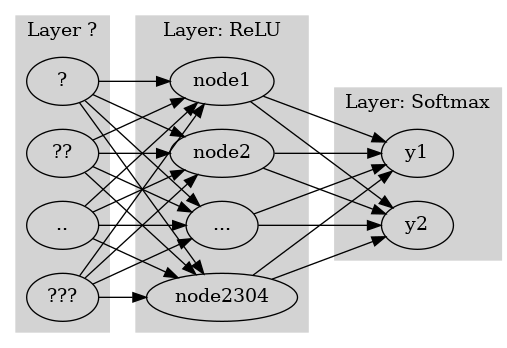

In [49]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y1"
    "node2" -> "y1"
    "..." -> "y1"
    "node2304" -> "y1"
    
    "node1" -> "y2"
    "node2" -> "y2"
    "..." -> "y2"
    "node2304" -> "y2"    
    label = "Layer: Softmax"
}
''')

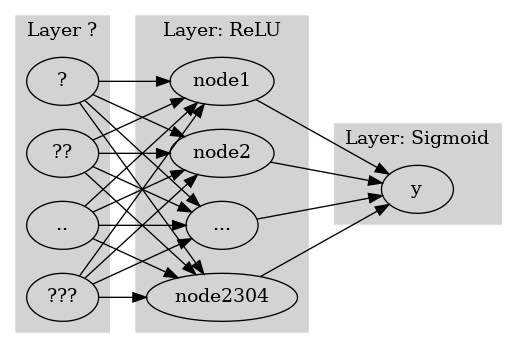

In [50]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node2304" -> "y"
    label = "Layer: Sigmoid"
}
''')

`-` 엄밀히 따지면 이는 파라메터의 낭비임. 하지만 Softmax를 생각하는 것은 다차원 카테고리로 확장이 용이하기 때문임. 만약에 개,고양이,사자를 구분해야하는 문제가 나온다면 sigmoid는 표현이 애매해지지만 softmax는 가능함.

`-` 결론 
1. 소프트맥스는 시그모이드의 확장이다. 
2. 클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고 클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를 사용해야 한다. 


`-` 그런데 사실.. 
1. 클래스의 수가 2개일 경우일때 (Softmax, CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (흑백이미지를 칼라잉크로 출력하는 느낌) 
2. 실제로 클래스의 수가 2개일때 (Softmax, CrossEntropyLoss)를 많이 사용 (왜? transfer learning)


***참고***

|$y$|분포가정|마지막층의 활성화함수|손실함수(파이토치)|
|:--:|:--:|:--:|:--:|
|3.45, 4.43, ... (연속형) |정규분포|None (or Linear)|MSE|
|0 or 1|이항분포 with $n=1$ (=베르누이) |Sigmoid| BCE|
|[0,0,1], [0,1,0], [1,0,0]| 다항분포 with $n=1$|Softmax| Cross Entropy |

## fastai metric 사용 

### 데이터준비

`-` download data 

In [51]:
path = untar_data(URLs.MNIST)

`-` training set 

In [52]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set 

In [53]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [54]:
X.shape,XX.shape,y.shape,yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

### 사용자정의 메트릭이용 

(1) dls 만들기

In [55]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [56]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() 

In [57]:
def acc(yhat,y) : 
    return ((yhat>0.5)==y).float().mean()

In [58]:
def err(yhat,y):
    return 1-((yhat>0.5)==y).float().mean()    

In [59]:
lrnr = Learner(dls,net,loss_fn,metrics=[acc,err])

(3) 학습

In [60]:
lrnr.fit(10)

epoch,train_loss,valid_loss,acc,err,time
0,0.876846,0.638790,0.463357,0.536643,00:00
1,0.700583,0.469180,0.983924,0.016076,00:00
2,0.573863,0.302658,0.994326,0.005674,00:00
3,0.460234,0.161171,0.995272,0.004728,00:00
4,0.361037,0.083815,0.995272,0.004728,00:00
5,0.282819,0.049708,0.995745,0.004255,00:00
6,0.223562,0.033868,0.996217,0.003783,00:00
7,0.178702,0.025456,0.996690,0.003310,00:00
8,0.144329,0.020331,0.996690,0.003310,00:00
9,0.117636,0.016863,0.997163,0.002837,00:00


(4) 예측

- 생략

### fastai지원 메트릭이용-- 잘못된사용 

(1) dls 만들기

In [61]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [62]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy,error_rate])

In [63]:
accuracy??

Signature: accuracy(inp, targ, axis=-1)
Source:   
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()
File:      ~/anaconda3/envs/py37/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


In [64]:
error_rate??

Signature: error_rate(inp, targ, axis=-1)
Source:   
def error_rate(inp, targ, axis=-1):
    "1 - `accuracy`"
    return 1 - accuracy(inp, targ, axis=axis)
File:      ~/anaconda3/envs/py37/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


(3) 학습

In [65]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.073563,0.631274,0.463357,0.536643,00:00
1,0.702278,0.401961,0.463357,0.536643,00:00
2,0.556878,0.238799,0.463357,0.536643,00:00
3,0.439178,0.131893,0.463357,0.536643,00:00
4,0.342415,0.079794,0.463357,0.536643,00:00
5,0.268883,0.052788,0.463357,0.536643,00:00
6,0.214080,0.038388,0.463357,0.536643,00:00
7,0.172624,0.029737,0.463357,0.536643,00:00
8,0.140634,0.024143,0.463357,0.536643,00:00
9,0.115579,0.020215,0.463357,0.536643,00:00


- 이상하다..? 

(4) 예측 

In [66]:
lrnr.model.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

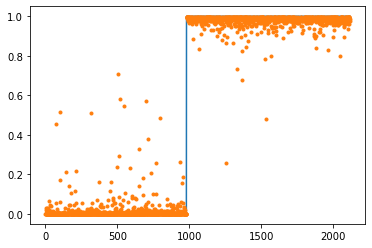

In [67]:
plt.plot(yy)
plt.plot(lrnr.model(XX).data,'.')

- 맞추는건 잘 맞추는데? 

### fastai지원 메트릭이용-- 올바른 사용(1)

`-` 가정 (아니 이걸 우리가 어떻게 알어) 
- X의 형태는 (n,채널,픽셀,픽셀)로 가정한다. 
- y의 형태는 (n,) 벡터이다. 즉 $n\times 1$ 이 아니라 그냥 길이가 $n$인 벡터로 가정한다. 
- y의 각 원소는 카테고리를 의미하는 숫자이어야 하며 이 숫자는 int형으로 저장되어야 한다. 
- loss function은 CrossEntropyLoss()를 쓴다고 가정한다. (따라서 네트워크의 최종레이어는 torch.nn.Linear(?,클래스의수) 꼴이 되어야 한다.)

(1) dls 만들기

In [68]:
y.to(torch.int64).reshape(-1),yy.to(torch.int64).reshape(-1)

(tensor([0, 0, 0,  ..., 1, 1, 1]), tensor([0, 0, 0,  ..., 1, 1, 1]))

In [69]:
ds1 = torch.utils.data.TensorDataset(X,y.to(torch.int64).reshape(-1))
ds2 = torch.utils.data.TensorDataset(XX,yy.to(torch.int64).reshape(-1))
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [70]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy,error_rate])

(3) 학습

In [71]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.229312,0.664340,0.463357,0.536643,00:00
1,0.752775,0.358362,0.963593,0.036407,00:00
2,0.563245,0.174521,0.989125,0.010875,00:00
3,0.421677,0.082398,0.995272,0.004728,00:00
4,0.317272,0.046382,0.996217,0.003783,00:00
5,0.242585,0.029040,0.996217,0.003783,00:00
6,0.188786,0.020572,0.996690,0.003310,00:00
7,0.149161,0.015709,0.997636,0.002364,00:00
8,0.119234,0.012618,0.998109,0.001891,00:00
9,0.096196,0.010482,0.998109,0.001891,00:00


### fastai지원 메트릭이용-- 올바른 사용(2)

`-` 가정 (아니 이걸 우리가 어떻게 알어) 
- X의 형태는 (n,채널,픽셀,픽셀)로 가정한다. 
- y의 형태는 (n,클래스의수)로 가정한다. 즉 y가 one_hot 인코딩된 형태로 가정한다. 
- y의 각 원소는 0 혹은 1이다. 
- loss function은 CrossEntropyLoss()를 쓴다고 가정한다. (따라서 네트워크의 최종레이어는 torch.nn.Linear(?,클래스의수) 꼴이 되어야 한다.)

(1) dls 만들기

In [72]:
y_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], y)))
yy_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], yy)))
# y_onehot = torch.nn.functional.one_hot(y.reshape(-1).to(torch.int64)).to(torch.float32)
# yy_onehot = torch.nn.functional.one_hot(yy.reshape(-1).to(torch.int64)).to(torch.float32)

In [73]:
ds1 = torch.utils.data.TensorDataset(X,y_onehot)
ds2 = torch.utils.data.TensorDataset(XX,yy_onehot)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [74]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss() 
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy_multi])

(3) 학습

In [75]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.157337,0.628012,0.463357,00:00
1,0.720004,0.383313,0.934279,00:00
2,0.555214,0.175862,0.990544,00:00
3,0.416784,0.082117,0.996454,00:00
4,0.313517,0.045678,0.996690,00:00
5,0.240043,0.029531,0.996690,00:00
6,0.187357,0.021700,0.996690,00:00
7,0.148566,0.017067,0.997163,00:00
8,0.119246,0.014031,0.997400,00:00
9,0.096650,0.011856,0.998109,00:00


## Transfer Learning 

In [76]:
path = untar_data(URLs.CIFAR)

In [77]:
path.ls()

(#3) [Path('/home/cgb4/.fastai/data/cifar10/labels.txt'),Path('/home/cgb4/.fastai/data/cifar10/train'),Path('/home/cgb4/.fastai/data/cifar10/test')]

### 수제네트워크

(1) dls 바로 만들기

In [78]:
dls = ImageDataLoaders.from_folder(path,train='train',valid='test',bs=1024)

In [79]:
_X, _y = dls.one_batch()
_X.shape, _y.shape

(torch.Size([1024, 3, 32, 32]), torch.Size([1024]))

(2) lrnr 생성 

In [80]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3,128,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)   

In [81]:
net1(_X.to("cpu")).shape

torch.Size([1024, 25088])

In [82]:
net2 = torch.nn.Sequential(
    torch.nn.Linear(25088,40),
    torch.nn.ReLU(),
    torch.nn.Linear(40,10)
)

In [83]:
net = torch.nn.Sequential(net1,net2)
net

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Sequential(
    (0): Linear(in_features=25088, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=10, bias=True)
  )
)

In [84]:
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls,net,loss_fn,metrics=accuracy) 

(3) 학습

In [85]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.896083,1.669411,0.402800,00:05
1,1.651008,1.487324,0.466500,00:05
2,1.503483,1.388984,0.500100,00:05
3,1.403136,1.323338,0.530000,00:05
4,1.337740,1.285825,0.544400,00:05
5,1.284242,1.256231,0.557600,00:05
6,1.240625,1.232869,0.564700,00:05
7,1.207515,1.204743,0.567900,00:05
8,1.177193,1.210030,0.568200,00:05
9,1.148627,1.165169,0.587500,00:05


- 이게 잘 안맞음.. 

### 전이학습 (남이 만든 네트워크)

(2) lrnr 생성 

In [86]:
net = torchvision.models.resnet34(weights=torchvision.models.resnet.ResNet34_Weights.IMAGENET1K_V1)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 출력이 1000 

In [87]:
net.fc = torch.nn.Linear(in_features=512, out_features=10)
# net[-1] 로는 접근불가

In [88]:
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls,net,loss_fn,metrics=accuracy) 

(3) 학습

In [89]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.847669,0.662988,0.775200,00:06
1,0.574675,0.616530,0.797500,00:05
2,0.411269,0.753529,0.763900,00:05
3,0.295243,0.728877,0.793800,00:05
4,0.221147,0.685063,0.813200,00:06
5,0.162376,0.815881,0.788100,00:05
6,0.125726,0.684423,0.818000,00:05
7,0.102262,0.865732,0.790900,00:05
8,0.086472,0.768470,0.819200,00:05
9,0.071308,0.823694,0.816300,00:05


- 원래 Resnet34가 이거 맞출려고 만든 네트워크는 아니에요 
- 그래도 일반인이 설계하는거보다 잘 맞아요 

(4) 예측 

### 전이학습 다른 구현: 순수 fastai 이용 

`-` 예전코드 복습

In [90]:
path = untar_data(URLs.PETS)/'images'

In [91]:
files= get_image_files(path)

In [92]:
def label_func(fname):
    if fname[0].isupper():
        return 'cat'
    else:
        return 'dog'

In [93]:
dls = ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

In [94]:
lrnr = vision_learner(dls,resnet34,metrics=accuracy) 

/home/cgb4/anaconda3/envs/py37/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/cgb4/anaconda3/envs/py37/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [95]:
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.166925,0.026891,0.989175,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.084257,0.020875,0.993234,00:38


`-` 사실 위의 코드가 transfer learning 이었음. 

In [96]:
lrnr.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## CAM

### motive 

### 구현0단계-- 예비학습

#### `#` 하나의 이미지 선택 

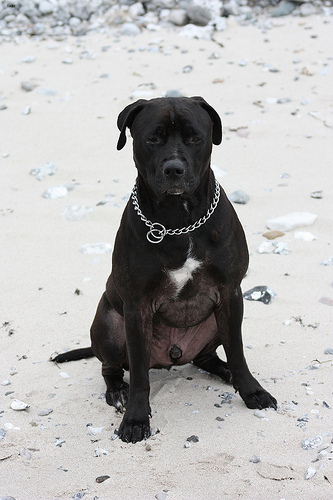

In [97]:
ximg = PILImage.create('/home/cgb4/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_106.jpg')
ximg

In [98]:
x, = first(dls.test_dl([ximg]))
x

TensorImage([[[[1.8379, 1.8379, 1.8550,  ..., 1.8379, 1.8379, 1.8379],
               [1.8379, 1.8379, 1.8550,  ..., 1.8379, 1.8379, 1.8379],
               [1.8379, 1.8379, 1.8550,  ..., 1.8379, 1.8379, 1.8379],
               ...,
               [1.7009, 1.7180, 1.7352,  ..., 1.7694, 1.7523, 1.7352],
               [1.8379, 1.8037, 1.7694,  ..., 1.7352, 1.7523, 1.7352],
               [1.7523, 1.7523, 1.7352,  ..., 1.7180, 1.7523, 1.7523]],

              [[2.0434, 2.0434, 2.0609,  ..., 2.0084, 2.0084, 2.0084],
               [2.0434, 2.0434, 2.0609,  ..., 2.0084, 2.0084, 2.0084],
               [2.0434, 2.0434, 2.0609,  ..., 2.0084, 2.0084, 2.0084],
               ...,
               [1.8859, 1.9034, 1.9209,  ..., 1.8683, 1.8333, 1.7983],
               [2.0259, 1.9909, 1.9384,  ..., 1.8683, 1.8508, 1.8158],
               [1.9384, 1.9384, 1.8859,  ..., 1.8859, 1.8683, 1.8508]],

              [[2.2391, 2.2391, 2.2566,  ..., 2.2566, 2.2566, 2.2566],
               [2.2391, 2.2391, 2

#### `#` AP layer 

In [99]:
ap = torch.nn.AdaptiveAvgPool2d(output_size=1)

In [100]:
X = torch.arange(48).reshape(1,3,4,4)*1.0
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]],

         [[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]]]])

In [101]:
ap(X)

tensor([[[[ 7.5000]],

         [[23.5000]],

         [[39.5000]]]])

In [102]:
X[0,0,...].mean(),X[0,1,...].mean(),X[0,2,...].mean()

(tensor(7.5000), tensor(23.5000), tensor(39.5000))

### 구현1단계-- 이미지분류 잘하는 네트워크 선택 

`-` 일단 예전 실습코드 그대로 

In [103]:
path = untar_data(URLs.PETS)/'images'
files= get_image_files(path)
def label_func(fname):
    if fname[0].isupper():
        return 'cat'
    else:
        return 'dog'
dls = ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

In [104]:
lrnr = vision_learner(dls,resnet34,metrics=accuracy) 
# 원래 cnn_learner 였는데 갑자기 이름을 바꾸라고 난리쳐서 그냥 바꿨어요..

/home/cgb4/anaconda3/envs/py37/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/cgb4/anaconda3/envs/py37/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [105]:
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.166098,0.029352,0.992558,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.034657,0.006326,0.997294,00:38


### 구현2단계-- 네트워크의 끝 부분 수정 

`-` 모형분해

In [106]:
net1 = lrnr.model[0] 
net2 = lrnr.model[1] 

`-` net2를 좀 더 살펴보자. 

In [107]:
net2

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [108]:
_X, _y =dls.one_batch()

In [109]:
print(net1(_X).shape)
print(net2[0](net1(_X)).shape)
print(net2[1](net2[0](net1(_X))).shape)

torch.Size([64, 512, 16, 16])
torch.Size([64, 1024, 1, 1])
torch.Size([64, 1024])


`-` net2를 아래와 같이 수정하고 재학습하자. (resnet 네트워크를 조금 망가뜨리는 거긴 한데 크게 영향없음) --> ***그런데 왜 이렇게 해????***

In [110]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(512,2) 
)

In [111]:
net = torch.nn.Sequential(
    net1,
    net2
)

In [112]:
lrnr2 = Learner(dls,net,metrics=accuracy) # loss_fn은?

In [113]:
lrnr2.loss_func, lrnr.loss_func # 알아서 기존 loss Funtion으로 잘 들어가 있음 

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of CrossEntropyLoss())

In [114]:
lrnr2.fine_tune(5) ## net2를 좀 수정해서 accuracy가 별로 안좋아졌지만 이정도면 쓸만함 

epoch,train_loss,valid_loss,accuracy,time
0,0.296802,4.657782,0.390392,00:38


epoch,train_loss,valid_loss,accuracy,time
0,0.160849,0.246485,0.904601,00:38
1,0.131739,0.136757,0.949256,00:38
2,0.107996,0.076989,0.973613,00:38
3,0.053509,0.047144,0.984438,00:38
4,0.027937,0.044781,0.982409,00:38


### 구현3단계-- 수정된 net2에서 Linear와 AP의 순서를 바꿈 

`-` 1개의 observation을 고정하였을 경우 출력과정 상상 

In [115]:
net2

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=True)
)

In [116]:
print(net1(x).shape)
print(net2[0](net1(x)).shape)
print(net2[1](net2[0](net1(x))).shape)
print(net2[2](net2[1](net2[0](net1(x)))).shape)

torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 2])


`-` 최종결과 확인 

In [117]:
net2(net1(x))

TensorImage([[-9.6371,  8.0407]], device='cuda:0', grad_fn=<AliasBackward0>)

- net2의 순서 바꾸기 전 전체 네트워크: $\quad \underset{(1,3,224,224)}{\boldsymbol x} \overset{net_1}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{ap}{\to} \underset{(1,512,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,512)}{{\boldsymbol \sharp}}\overset{linear}{\to} \underset{(1,2)}{\hat{\boldsymbol y}}\right) = [-7.0107,  8.0188]$

`-` 아래와 같이 순서를 바꿔서 한번 계산해보고 싶다. (왜???..)

- net2의 순서를 바꾼 후 전체 네트워크: $\quad \underset{(1,3,224,224)}{\boldsymbol x} \overset{net_1}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{linear}{\to} \underset{(1,2,16,16)}{{\bf why}}\overset{ap}{\to} \underset{(1,2,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,2)}{\hat{\boldsymbol y}}\right) = [-7.0107,  8.0188]$

- 여기에서 (1,512,16,16) -> (1,2,16,16) 로 가는 선형변환을 적용하는 방법? **(16,16) each pixel에 대하여 (512 $\to$ 2)로 가는 변환을 수행**

`-` 통찰: 이 경우 특이하게도 레이어의 순서를 바꿨을때 출력이 동일함 (선형변환하고 평균내거나 평균내고 선형변환하는건 같으니까) 

In [118]:
_x =torch.tensor([1,2,3.14,4]).reshape(4,1)
_x 

tensor([[1.0000],
        [2.0000],
        [3.1400],
        [4.0000]])

In [119]:
_l1 = torch.nn.Linear(1,1)
_l1(_x).mean()

tensor(-2.2885, grad_fn=<MeanBackward0>)

In [120]:
_l1(_x.mean().reshape(1,1))

tensor([[-2.2885]], grad_fn=<AddmmBackward0>)

`-` 구현해보자. 

In [121]:
net1(x).shape, net2[2].weight.shape

(torch.Size([1, 512, 16, 16]), torch.Size([2, 512]))

(구현1)

In [122]:
(net2[2].weight @ net1(x)[0,:,0,0]).detach().to("cpu").tolist() ## 연습

[-1.0527231693267822, 0.559443473815918]

In [123]:
# (net2[2].weight @ net1(x)[0,:,0,0]).detach().to("cpu").tolist() 

(구현2)

In [124]:
net2[2].weight.shape, net1(x).shape

(torch.Size([2, 512]), torch.Size([1, 512, 16, 16]))

- 입력 (2,512) @ (1,512,7,7) => 출력 (1,2,16,16) 

In [125]:
torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))

TensorImage([[[[-1.0527e+00, -1.2432e+00, -2.9768e-01,  2.5445e-01,  3.5283e-01,
                -6.0576e-01, -3.7851e+00, -6.2304e+00, -6.0731e+00, -3.6333e+00,
                -1.1263e+00, -8.0933e-02, -7.2726e-01, -9.4467e-01, -5.2882e-01,
                -2.3971e-01],
               [-1.6551e+00, -6.1476e-01,  1.1963e-02,  3.2230e-01,  1.9609e-02,
                -6.0425e+00, -2.0121e+01, -3.2455e+01, -3.3749e+01, -2.2528e+01,
                -9.2451e+00, -1.9956e+00, -1.0817e+00, -9.9412e-01, -9.7951e-01,
                -5.7937e-01],
               [ 9.5893e-04,  2.6703e-01,  8.7416e-01,  9.3664e-01,  1.1792e-01,
                -1.3664e+01, -4.3776e+01, -7.1986e+01, -7.4288e+01, -5.4776e+01,
                -2.9194e+01, -6.9693e+00, -6.2317e-01,  7.0943e-02, -1.6915e-01,
                -2.3920e-01],
               [-3.9809e-02,  5.2603e-01,  6.4145e-01,  6.0424e-01, -1.3443e-01,
                -1.7374e+01, -5.5872e+01, -9.8563e+01, -1.0671e+02, -8.3060e+01,
                -4.

In [126]:
why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
why.shape

torch.Size([1, 2, 16, 16])

In [127]:
net2[1](net2[0](why)), net2(net1(x))

(TensorImage([[-9.6422,  8.0510]], device='cuda:0', grad_fn=<AliasBackward0>),
 TensorImage([[-9.6371,  8.0407]], device='cuda:0', grad_fn=<AliasBackward0>))

- 이게 원래 같은 숫자에요 

### 잠깐 멈추고 생각

`-` 이미지

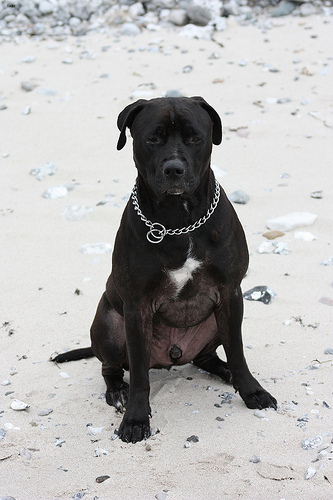

In [128]:
ximg

`-` 결과 

In [129]:
net2(net1(x))

TensorImage([[-9.6371,  8.0407]], device='cuda:0', grad_fn=<AliasBackward0>)

"-7.0107 <<  8.0188" 이므로 `ximg`는 높은 확률로 개를 의미함

`-` 아래의 네트워크 관찰 

$$\underset{(1,2,7,7)}{{\bf why}}\overset{ap}{\to} \underset{(1,2,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,2)}{\hat{\boldsymbol y}} = [-7.0107,  8.0188]$$

In [130]:
net2[0](why)
#net2[1](net2[0](why)) ## 일단 flattn은 숫자와 상관없으므로 생각안해도 무방

TensorImage([[[[-9.6422]],

              [[ 8.0510]]]], device='cuda:0', grad_fn=<AliasBackward0>)

더 파고들어서 분석해보자. 

In [131]:
why.shape

torch.Size([1, 2, 16, 16])

- why[0,0,:,:] -> 평균 -> -7.9513
- why[0,1,:,:] -> 평균 -> 8.5888

In [132]:
torch.mean(why[0,0,:,:])

TensorImage(-9.6422, device='cuda:0', grad_fn=<AliasBackward0>)

In [133]:
torch.mean(why[0,1,:,:])

TensorImage(8.0510, device='cuda:0', grad_fn=<AliasBackward0>)

***`why[0,0,:,:]`***

In [134]:
why[0,0,:,:] 

TensorImage([[-1.0527e+00, -1.2432e+00, -2.9768e-01,  2.5445e-01,  3.5283e-01,
              -6.0576e-01, -3.7851e+00, -6.2304e+00, -6.0731e+00, -3.6333e+00,
              -1.1263e+00, -8.0933e-02, -7.2726e-01, -9.4467e-01, -5.2882e-01,
              -2.3971e-01],
             [-1.6551e+00, -6.1476e-01,  1.1963e-02,  3.2230e-01,  1.9609e-02,
              -6.0425e+00, -2.0121e+01, -3.2455e+01, -3.3749e+01, -2.2528e+01,
              -9.2451e+00, -1.9956e+00, -1.0817e+00, -9.9412e-01, -9.7951e-01,
              -5.7937e-01],
             [ 9.5893e-04,  2.6703e-01,  8.7416e-01,  9.3664e-01,  1.1792e-01,
              -1.3664e+01, -4.3776e+01, -7.1986e+01, -7.4288e+01, -5.4776e+01,
              -2.9194e+01, -6.9693e+00, -6.2317e-01,  7.0943e-02, -1.6915e-01,
              -2.3920e-01],
             [-3.9809e-02,  5.2603e-01,  6.4145e-01,  6.0424e-01, -1.3443e-01,
              -1.7374e+01, -5.5872e+01, -9.8563e+01, -1.0671e+02, -8.3060e+01,
              -4.3389e+01, -1.1445e+01,  1.1607

***`why[0,1,:,:]`***

In [135]:
why[0,1,:,:] 

TensorImage([[ 5.5944e-01,  5.6036e-01,  5.9529e-02, -3.0949e-01, -4.0391e-01,
               4.7538e-01,  3.4440e+00,  5.7189e+00,  5.6294e+00,  3.3737e+00,
               9.9299e-01, -5.0516e-02,  2.8460e-01,  4.4709e-01,  1.5475e-01,
               8.1802e-02],
             [ 1.0602e+00,  4.5009e-01,  4.9709e-02, -1.4981e-01,  2.1135e-02,
               5.6156e+00,  1.8100e+01,  2.9802e+01,  3.0822e+01,  2.0484e+01,
               8.2761e+00,  1.6287e+00,  6.5201e-01,  7.0116e-01,  7.9027e-01,
               4.4022e-01],
             [ 1.1552e-01, -7.6205e-02, -4.8846e-01, -5.4068e-01, -5.1796e-02,
               1.2193e+01,  3.9337e+01,  6.6176e+01,  6.7231e+01,  4.9450e+01,
               2.5384e+01,  5.5250e+00,  4.6099e-01,  1.5959e-02,  1.7005e-01,
               1.8282e-01],
             [ 8.0179e-02, -2.7451e-01, -3.6917e-01, -3.2915e-01,  9.6876e-02,
               1.5146e+01,  4.8931e+01,  8.7644e+01,  9.4200e+01,  7.2586e+01,
               3.5986e+01,  8.9342e+00, -9.3196

- 이 값들의 평균은 8.8588 
- 그런데 대부분의 위치에서 8.8588보다 작음 거의 0근처. 특정위치에서 엄청 큰 값이 있어서 8.8588 이라는 값이 나옴. $\to$ 특정위치에서 엄청 큰 값이 있어서 강아지라고 판단하는 근거가 확실하게 되었음. 

`-` 시각화(1)

In [136]:
why_cat = why[0,0,:,:]
why_dog = why[0,1,:,:]

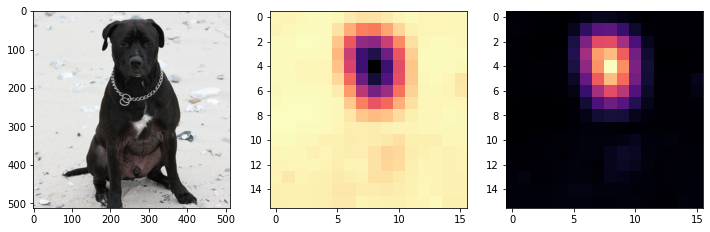

In [137]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(torch.einsum('ocij -> ijc', dls.decode((x,))[0]))
ax[1].imshow(why_cat.to("cpu").detach(),cmap='magma')
ax[2].imshow(why_dog.to("cpu").detach(),cmap='magma')

- magma: 검-보-빨-노 순으로 값이 크다.
- 3번째그림의 노랑색: 강아지라고 생각한 근거 
- 2번째그림의 검은색: 고양이가 아니라 생각한 근거 

`-` 시각화(2) 

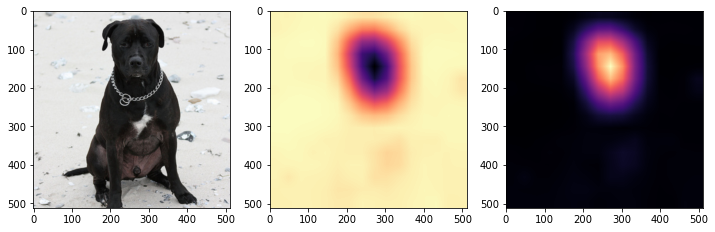

In [138]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(torch.einsum('ocij -> ijc', dls.decode((x,))[0]))
ax[1].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear')
ax[2].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear')

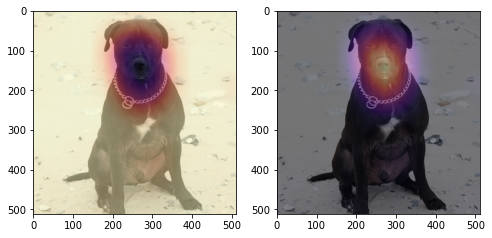

In [139]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc', dls.decode((x,))[0]))
ax[0].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[1].imshow(torch.einsum('ocij -> ijc', dls.decode((x,))[0]))
ax[1].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5) 

`-` 하니이미지 시각화 

In [140]:
#
# !wget https://github.com/guebin/DL2022/blob/master/_notebooks/2022-09-06-hani01.jpeg?raw=true  ## 코랩에서는 이거 한번 실행하면 이미지파일 저장됩니다
ximg = PILImage.create('2022-09-06-hani01.jpeg') 
x, = first(dls.test_dl([ximg]))

In [141]:
why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
why_cat = why[0,0,:,:] 
why_dog = why[0,1,:,:] 

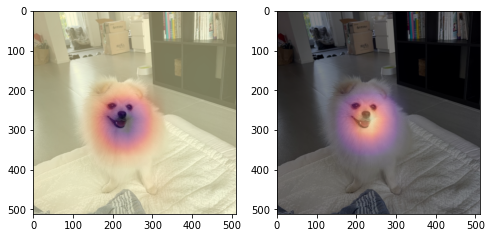

In [142]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc', dls.decode((x,))[0]))
ax[0].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[1].imshow(torch.einsum('ocij -> ijc', dls.decode((x,))[0]))
ax[1].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5) 

In [143]:
sftmax(net(x))[0][0].item(),sftmax(net(x))[0][1].item()

(0.0003606161626521498, 0.9996393918991089)

Text(0.5, 1.0, 'dog 0.999639')

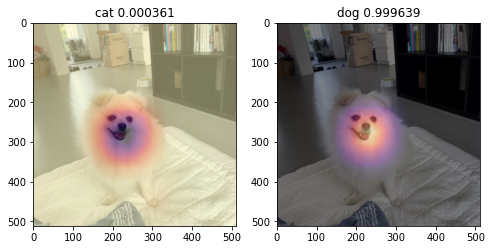

In [144]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc', dls.decode((x,))[0]))
ax[0].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[0].set_title('cat %f' %sftmax(net(x))[0][0].item())
ax[1].imshow(torch.einsum('ocij -> ijc', dls.decode((x,))[0]))
ax[1].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5) 
ax[1].set_title('dog %f' %sftmax(net(x))[0][1].item())

### 구현4단계-- CAM 시각화 

In [ ]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cat = why[0,0,:,:] 
        why_dog = why[0,1,:,:] 
        catprob, dogprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if catprob>dogprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cat.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%2f)" % catprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_dog.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%2f)" % dogprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(5,5) 
k=25
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cat = why[0,0,:,:] 
        why_dog = why[0,1,:,:] 
        catprob, dogprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if catprob>dogprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cat.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%2f)" % catprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_dog.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%2f)" % dogprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(5,5) 
k=50
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cat = why[0,0,:,:] 
        why_dog = why[0,1,:,:] 
        catprob, dogprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if catprob>dogprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cat.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%2f)" % catprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_dog.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%2f)" % dogprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [ ]:
## fig, ax = plt.subplots(5,5) 
k=75
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cat = why[0,0,:,:] 
        why_dog = why[0,1,:,:] 
        catprob, dogprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if catprob>dogprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cat.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%2f)" % catprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_dog.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%2f)" % dogprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()